<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


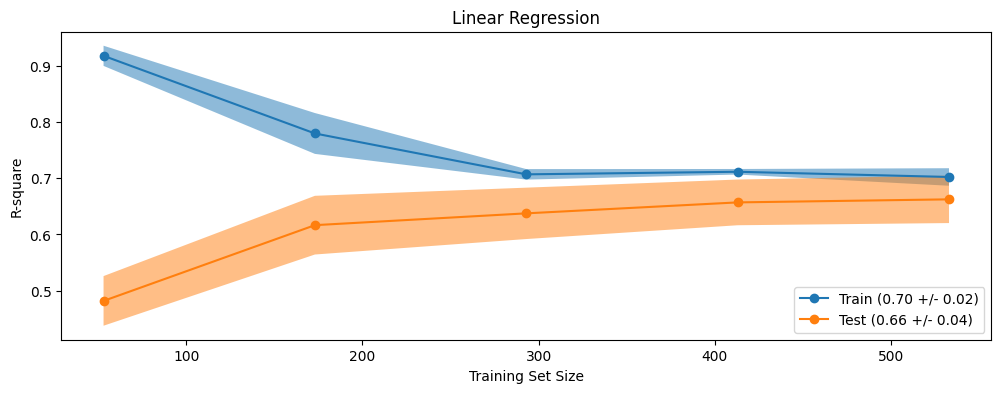

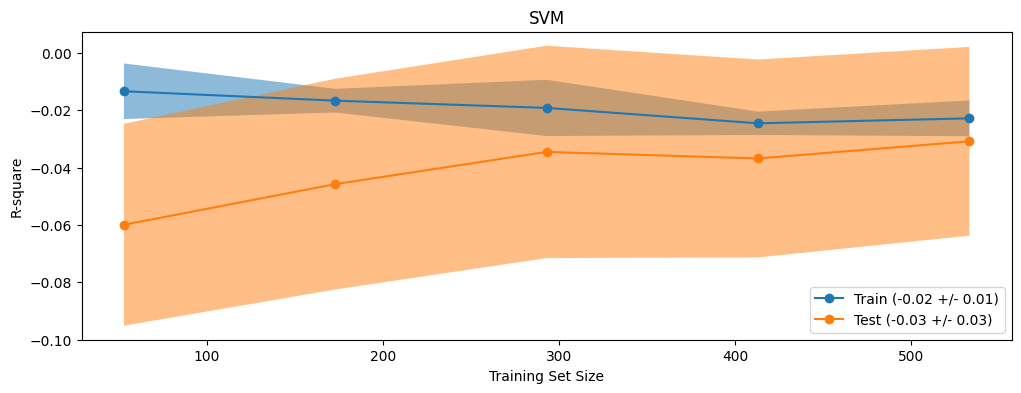

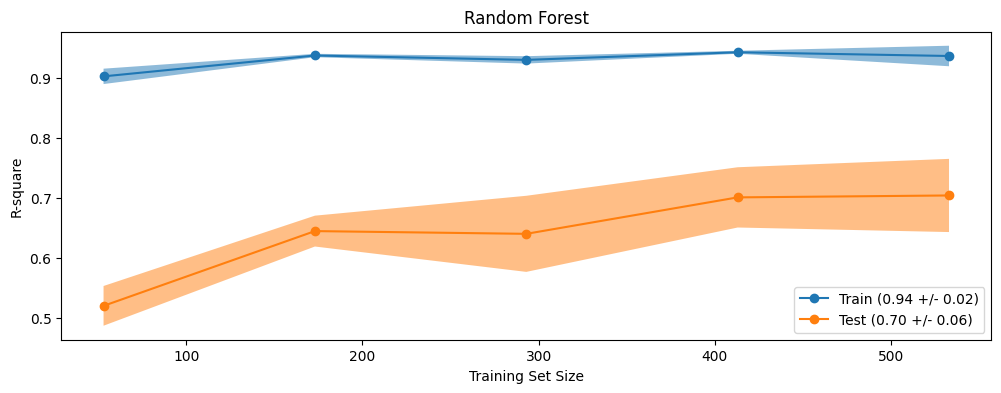

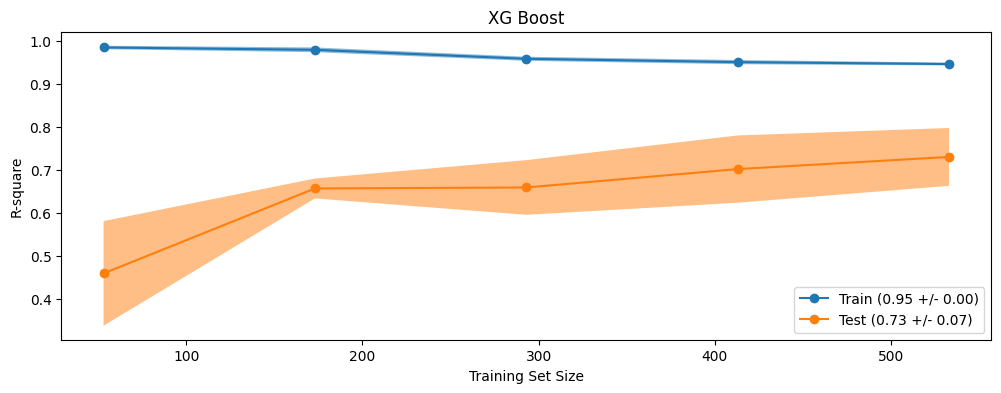

In [1]:
# Importing Libraries

import pandas as pd
import numpy as np

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score

from feature_engine.datetime import DatetimeFeatures

import joblib

import matplotlib.pyplot as plt

# Display Settings

pd.set_option("display.max_columns", None)

sklearn.set_config(transform_output="default")

# Getting the Data

train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
val_df = pd.read_csv("data/val.csv")

### 3.1 Split the data

def split_data(data):
    X = data.drop(columns="price")
    y = data.price.copy()
    return (X,y)

X_train, y_train = split_data(train_df)

X_val, y_val = split_data(val_df)
X_test, y_test = split_data(test_df)

## 3.2 Meta-Info

X_train.info()

# 4. Data Preprocessing

dt_cols = ["date_of_journey","dep_time","arrival_time"]

num_cols = ["duration","total_stops"]

cat_cols = [cols for cols in X_train.columns if (cols not in dt_cols) and (cols not in num_cols)]

cat_cols

num_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))])

doj_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["month","week","day_of_week","day_of_month"],format="mixed")),
    ("scaler", StandardScaler())
])

time_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["hour","minute"],format="mixed")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("time", time_transformer, ["dep_time","arrival_time"])
    
])

preprocessor.fit_transform(X_train)

## 5. Model Selection

algorithms = {
    "Linear Regression" : LinearRegression(),
    "SVM" : SVR(),
    "Random Forest" : RandomForestRegressor(n_estimators=10),
    "XG Boost" : XGBRegressor(n_estimators=10)
}

data = pd.concat([train_df, val_df], axis = 0)
data

X_data, y_data = split_data(data)

def plot_curves(sizes, mean_scores, std_scores, label, ax):
    ax.plot(
        sizes,
        mean_scores,
        marker="o",
        label = label
    )
    ax.fill_between(
        x=sizes,
        y1=mean_scores - std_scores,
        y2=mean_scores + std_scores,
        alpha = 0.5
    )

def plot_learning_curve(name, algorithm, figsize = (12,4)):
    model = Pipeline(steps=[
        ("pre", preprocessor),
        ("alg", algorithm)        
    ])

    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X_data,
        y=y_data,
        cv=3,
        scoring = "r2",
        n_jobs=-1,
        random_state=42        
    )

    mean_train_scores = np.mean(train_scores, axis = 1)
    std_train_scores = np.std(train_scores, axis = 1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

    mean_test_scores = np.mean(test_scores, axis = 1)
    std_test_scores = np.std(test_scores, axis = 1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

    fig, ax = plt.subplots(figsize=figsize)

    #training curves
    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train ({train_score})",
        ax
    )

    #test curves
    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test ({test_score})",
        ax
    )

    ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)
    ax.legend(loc="lower right")

    plt.show()

for name, alg in algorithms.items():
    plot_learning_curve(name, alg)



In [2]:
model = Pipeline(steps=[
    ("pre",preprocessor),
    ("rf", RandomForestRegressor(n_estimators=10))   
] 
)

In [3]:
model.fit(X_data,y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

## Model Evaluation

In [4]:
def evaluate_model(X,y):
    y_pred = model.predict(X)
    return r2_score(y,y_pred)

In [5]:
print(f"R2 score on Training data is = {evaluate_model(X_data,y_data)}")

R2 score on Training data is = 0.9573329608860183


In [6]:
print(f"R2 score on Test data is = {evaluate_model(X_test,y_test)}")

R2 score on Test data is = 0.6795041912846361


## Model Persistence

In [7]:
joblib.dump(model,"model.joblib")

['model.joblib']

In [8]:
saved_model = joblib.load("model.joblib")

In [9]:
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [10]:
y_pred = saved_model.predict(X_test)
r2_score(y_test,y_pred)

0.6795041912846361